# Modelo XGBoost

### Importar Librerías

In [1]:
import pandas as pd
from pandas import DataFrame, concat
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
import warnings
warnings.filterwarnings("ignore")

### 1. Cargar Datos

In [2]:
file_path = '/kaggle/input/data-general/data.csv'
data = pd.read_csv(file_path)
data['Fecha'] = pd.to_datetime(data['Fecha'])
data.set_index('Fecha', inplace=True)
data

,Ventas,Festivo,IsWeekend,DiaSemanaNum,DiaSemana_0,DiaSemana_1,DiaSemana_2,DiaSemana_3,DiaSemana_4,DiaSemana_5,DiaSemana_6,Ventas_Log,Ventas_Loess,Ventas_Log_Loess
Fecha,,,,,,,,,,,,,,
2021-11-02,80413.11,0,0,1,0,1,0,0,0,0,0,11.294945,40312.848109,10.116158
2021-11-03,14889.17,0,0,2,0,0,1,0,0,0,0,9.608457,37468.585652,10.115608
2021-11-04,50003.14,0,0,3,0,0,0,1,0,0,0,10.819861,34770.377351,10.115075
2021-11-05,39607.01,0,0,4,0,0,0,0,1,0,0,10.586787,32190.561274,10.114560
2021-11-06,0.00,0,1,5,0,0,0,0,0,1,0,0.000000,29679.383004,10.114062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-27,305.76,0,1,5,0,0,0,0,0,1,0,5.726066,15895.584989,9.351941
2024-07-28,114.40,0,1,6,0,0,0,0,0,0,1,4.748404,15873.486611,9.350883
2024-07-29,14466.95,0,0,0,1,0,0,0,0,0,0,9.579691,15851.388234,9.349824


In [3]:
test_days=101

### 2. Definir Clases para entrenamiento con Grid Search

#### 2.1. XGBoost

In [4]:
class XGBoostTimeSeries:
    def __init__(self, data, target='Ventas', test_days=test_days):
        """
        Inicializa la clase con los datos, columna objetivo y tamaño de prueba.

        Parameters:
        - data: DataFrame original.
        - target: Nombre de la variable objetivo (default: 'Ventas').
        - test_days: Número de días para prueba (default: 101).
        """
        self.data = data.copy()
        self.target = target
        self.test_days = test_days

    def preprocess_data(self):
        self.train_data = self.data.iloc[:-self.test_days]
        self.test_data = self.data.iloc[-self.test_days:]

    def create_features(self, df):
        """
        Crea características adicionales:
        - rolling_mean de 7 días.
        - rolling_std de 7 días.
        - lags de 1, 7 y 14 días.
        """
        df = df.copy()

        # Crear rolling mean
        df['rolling_mean_7d'] = (
            df[self.target]
            .rolling(window=7, min_periods=1)
            .mean()
            .fillna(0)
        )

        # Crear rolling std
        df['rolling_std_7d'] = (
            df[self.target]
            .rolling(window=7, min_periods=1)
            .std()
            .fillna(0)
        )

        # Crear lags
        for lag in [1, 7, 14]:
            df[f'lag_{lag}'] = df[self.target].shift(lag).fillna(0)

        return df

    def train_model(self, manual_features=None):
        """
        Entrena el modelo de XGBoost utilizando RandomizedSearchCV con GPU habilitada.

        Parameters:
        - manual_features: list, características manuales seleccionadas por el usuario.
        Si no se especifica, se utiliza una lista predeterminada.
        """
        # Definir rango de hiperparámetros para RandomizedSearchCV
        param_distributions = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 10],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'reg_lambda': [1, 10],
            'reg_alpha': [0, 1],
            'tree_method': ['gpu_hist']  # Activar GPU
        }

        # Instanciar el modelo base
        xgb = XGBRegressor(random_state=42, objective='reg:squarederror', tree_method='gpu_hist')

        # Configurar RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=xgb,
            param_distributions=param_distributions,
            n_iter=50,
            scoring='neg_root_mean_squared_error',
            cv=3,
            verbose=1,
            random_state=42,
            n_jobs=-1
        )

        # Aplicar create_features para generar las variables adicionales
        self.train_data = self.create_features(self.train_data)
        self.test_data = self.create_features(self.test_data)

        # Usar las manual features proporcionadas o la lista predeterminada
        if manual_features is None:
            manual_features = [
                'Festivo', 'IsWeekend', 'DiaSemana_0', 'DiaSemana_1',
                'DiaSemana_2', 'DiaSemana_3', 'DiaSemana_4', 'DiaSemana_5', 'DiaSemana_6'
            ]
            
        generated_features = [
            'rolling_mean_7d', 'rolling_std_7d', 'lag_1', 'lag_7', 'lag_14'
        ]
        all_features = manual_features + generated_features

        # Separar las características y la variable objetivo
        X_train = self.train_data[all_features]
        y_train = self.train_data[self.target]

        # Entrenar con RandomizedSearchCV
        random_search.fit(X_train, y_train)

        # Guardar el mejor modelo y los resultados
        self.best_model = random_search.best_estimator_
        self.best_params = random_search.best_params_

        # Evaluar en el conjunto de prueba
        X_test = self.test_data[all_features]
        y_test = self.test_data[self.target]
        y_pred = self.best_model.predict(X_test)
        self.test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        print(f"Mejores hiperparámetros: {self.best_params}")
        print(f"RMSE en el conjunto de prueba: {self.test_rmse}")

        return self.best_model

    def plot_feature_importance(self):
        """
        Genera un gráfico de importancia de características basado en el modelo entrenado.
        """
        if not hasattr(self, 'best_model'):
            raise ValueError("El modelo no está entrenado. Llama a 'train_model()' primero.")

        plt.figure(figsize=(10, 8))
        plot_importance(self.best_model, importance_type='weight', title='Feature Importance', xlabel='F Score')
        plt.show()
    def evaluate_model_predictions(self):
        """
        Evalúa el modelo en los conjuntos de entrenamiento y prueba.
        Calcula las métricas RMSE y R², y almacena las predicciones.
        """
        # Definir las columnas para las características
        manual_features = [
            'Festivo', 'IsWeekend', 'DiaSemana_0', 'DiaSemana_1',
            'DiaSemana_2', 'DiaSemana_3', 'DiaSemana_4', 'DiaSemana_5', 'DiaSemana_6'
        ]
        generated_features = [
            'rolling_mean_7d', 'rolling_std_7d', 'lag_1', 'lag_7', 'lag_14'
        ]
        all_features = manual_features + generated_features

        # Separar características y objetivo
        X_train = self.train_data[all_features]
        y_train = self.train_data[self.target]
        X_test = self.test_data[all_features]
        y_test = self.test_data[self.target]

        # Predicciones en el conjunto de entrenamiento
        y_pred_train = self.best_model.predict(X_train)
        self.rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        self.r2_train = r2_score(y_train, y_pred_train)
        self.mae_train = mean_absolute_error(y_train, y_pred_train)

        # Predicciones en el conjunto de prueba
        y_pred_test = self.best_model.predict(X_test)
        self.rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        self.r2_test = r2_score(y_test, y_pred_test)
        self.mae_test = mean_absolute_error(y_test, y_pred_test)

        # Guardar las predicciones como DataFrames
        self.train_forecast_vs_actual = pd.DataFrame({
            'Actual': y_train,
            'Forecast': y_pred_train
        }, index=X_train.index)

        self.test_forecast_vs_actual = pd.DataFrame({
            'Actual': y_test,
            'Forecast': y_pred_test
        }, index=X_test.index)

        # Imprimir métricas
        print(f"RMSE Train: {self.rmse_train}")
        print(f"MAE Train: {self.mae_train}")        
        print(f"R² Train: {self.r2_train}")
        print(f"RMSE Test: {self.rmse_test}")
        print(f"MAE Test: {self.mae_test}")
        print(f"R² Test: {self.r2_test}")

    def generate_model_info(self, version):
        model_info = {
            'version': version,
            'model_name': self.best_model.__class__.__name__,
            'rmse_train': self.rmse_train,
            'mae_train':self.mae_train,
            'r2_train': self.r2_train,
            'rmse_test': self.rmse_test,
            'mae_test': self.mae_test,
            'r2_test': self.r2_test,
        }
        return model_info

    def plot_predictions(self, train_title, test_title, divided_title):
        """
        Genera tres gráficos personalizados con títulos proporcionados:
        1. Valores reales vs predicciones en el conjunto de entrenamiento.
        2. Valores reales vs predicciones en el conjunto de prueba.
        3. Gráfico combinado de entrenamiento y prueba con una línea divisoria.
        
        Parameters:
        - train_title: str, título para el gráfico de entrenamiento.
        - test_title: str, título para el gráfico de prueba.
        - divided_title: str, título para el gráfico con línea divisoria.
        """
        # Gráfico 1: Conjunto de entrenamiento
        plt.figure(figsize=(12, 6))
        plt.plot(self.train_forecast_vs_actual.index, self.train_forecast_vs_actual['Actual'], 
                label='Actual (Train)', marker='o', color='#1f77b4', linewidth=2, linestyle='-')
        plt.plot(self.train_forecast_vs_actual.index, self.train_forecast_vs_actual['Forecast'], 
                label='Forecast (Train)', marker='x', color='#ff7f0e', linewidth=2, linestyle='--')
        plt.title(train_title, fontsize=16, fontweight='bold', color='#333')
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Ventas', fontsize=14)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.xticks(rotation=45, ha='right', fontsize=10)
        formatter = ticker.FuncFormatter(lambda x, pos: '${:,.0f}K'.format(x * 1e-3))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
        plt.gca().set_facecolor('#f9f9f9')
        plt.legend(loc='upper left', fontsize=12)
        plt.tight_layout()
        plt.show()

        # Gráfico 2: Conjunto de prueba
        plt.figure(figsize=(12, 6))
        plt.plot(self.test_forecast_vs_actual.index, self.test_forecast_vs_actual['Actual'], 
                label='Actual (Test)', marker='o', color='#1f77b4', linewidth=2, linestyle='-')
        plt.plot(self.test_forecast_vs_actual.index, self.test_forecast_vs_actual['Forecast'], 
                label='Forecast (Test)', marker='x', color='#ff7f0e', linewidth=2, linestyle='--')
        plt.title(test_title, fontsize=16, fontweight='bold', color='#333')
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Ventas', fontsize=14)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
        plt.gca().set_facecolor('#f9f9f9')
        plt.legend(loc='upper left', fontsize=12)
        plt.tight_layout()
        plt.show()

        # Gráfico 3: Combinado con línea divisoria
        predictions = pd.concat([self.train_forecast_vs_actual['Forecast'], self.test_forecast_vs_actual['Forecast']], axis=0).to_frame(name='Predicted')
        predictions['Actual'] = pd.concat([self.train_forecast_vs_actual['Actual'], self.test_forecast_vs_actual['Actual']], axis=0)
        test_start_index = self.test_forecast_vs_actual.index.min()

        predictions_last_200 = predictions.tail(200)
        plt.figure(figsize=(12, 6))
        plt.plot(predictions_last_200.loc[:test_start_index].index, predictions_last_200.loc[:test_start_index, 'Actual'],
                label='Actual - Train', marker='o', color='#1f77b4', linewidth=2, linestyle='-')
        plt.plot(predictions_last_200.loc[:test_start_index].index, predictions_last_200.loc[:test_start_index, 'Predicted'],
                label='Forecast - Train', marker='x', color='#ff7f0e', linewidth=2, linestyle='--')
        plt.plot(predictions_last_200.loc[test_start_index:].index, predictions_last_200.loc[test_start_index:, 'Actual'],
                label='Actual - Test', marker='o', color='#2ca02c', linewidth=2, linestyle='-')
        plt.plot(predictions_last_200.loc[test_start_index:].index, predictions_last_200.loc[test_start_index:, 'Predicted'],
                label='Forecast - Test', marker='x', color='#d62728', linewidth=2, linestyle='--')

        plt.axvline(test_start_index, color='gray', linestyle='--', linewidth=1.5, label='División Train/Test')
        plt.title(divided_title, fontsize=16, fontweight='bold', color='#333')
        plt.xlabel('Fecha', fontsize=14)
        plt.ylabel('Ventas (USD)', fontsize=14)
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.ylim(0, 120000)  # Ajustar el rango del eje y (mejora visual)
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.gca().yaxis.set_tick_params(labelsize=10)
        plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
        plt.gca().set_facecolor('#f9f9f9')
        plt.legend(loc='upper left', fontsize=12)
        plt.tight_layout()
        plt.show()


#### 2.2. XGBoost Logarítmico

In [5]:
class XGBoostTimeSeriesLog(XGBoostTimeSeries):
    """
    Extiende la funcionalidad de XGBoostTimeSeries para trabajar con un target logarítmico.
    El target debe ser transformado como Log(Ventas) + 1.
    """

    def __init__(self, data, target='Ventas_Log', test_days=101):
        """
        Inicializa la clase con los datos, columna objetivo y tamaño de prueba.

        Parameters:
        - data: DataFrame original.
        - target: Nombre de la variable objetivo (default: 'Ventas_Log').
        - test_days: Número de días para prueba (default: 101).
        """
        super().__init__(data, target, test_days)

    def evaluate_model_predictions(self):
        """
        Evalúa el modelo en los conjuntos de entrenamiento y prueba.
        Calcula las métricas RMSE y R², y almacena las predicciones.
        En este caso, invierte la transformación logarítmica: exp(Ventas_Log) - 1.
        """
        # Definir las columnas para las características
        manual_features = [
            'Festivo', 'IsWeekend', 'DiaSemana_0', 'DiaSemana_1',
            'DiaSemana_2', 'DiaSemana_3', 'DiaSemana_4', 'DiaSemana_5', 'DiaSemana_6'
        ]
        generated_features = [
            'rolling_mean_7d', 'rolling_std_7d', 'lag_1', 'lag_7', 'lag_14'
        ]
        all_features = manual_features + generated_features

        # Separar características y objetivo
        X_train = self.train_data[all_features]
        y_train_log = self.train_data[self.target]
        X_test = self.test_data[all_features]
        y_test_log = self.test_data[self.target]

        # Invertir transformación para los valores reales
        y_train = (np.exp(y_train_log) - 1).clip(0)  # Evitar valores negativos por errores numéricos
        y_test = (np.exp(y_test_log) - 1).clip(0)

        # Predicciones en el conjunto de entrenamiento
        y_pred_train_log = self.best_model.predict(X_train)
        y_pred_train = (np.exp(y_pred_train_log) - 1).clip(0)

        # Predicciones en el conjunto de prueba
        y_pred_test_log = self.best_model.predict(X_test)
        y_pred_test = (np.exp(y_pred_test_log) - 1).clip(0)

        # Calcular métricas en entrenamiento
        self.rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        self.mae_train = mean_absolute_error(y_train, y_pred_train)
        self.r2_train = r2_score(y_train, y_pred_train)

        # Calcular métricas en prueba
        self.rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        self.mae_test = mean_absolute_error(y_test, y_pred_test)
        self.r2_test = r2_score(y_test, y_pred_test)

        # Guardar las predicciones como DataFrames
        self.train_forecast_vs_actual = pd.DataFrame({
            'Actual': y_train,
            'Forecast': y_pred_train
        }, index=X_train.index)

        self.test_forecast_vs_actual = pd.DataFrame({
            'Actual': y_test,
            'Forecast': y_pred_test
        }, index=X_test.index)

        # Imprimir métricas
        print(f"RMSE Train: {self.rmse_train}")
        print(f"MAE Train: {self.mae_train}")        
        print(f"R² Train: {self.r2_train}")
        print(f"RMSE Test: {self.rmse_test}")
        print(f"MAE Test: {self.mae_test}")
        print(f"R² Test: {self.r2_test}")

### 3. Serie sin Transformar

In [6]:
model = XGBoostTimeSeries(data=data, target='Ventas', test_days=test_days)
model.preprocess_data()
model.train_model(manual_features=['Festivo', 'IsWeekend','DiaSemana_0','DiaSemana_1','DiaSemana_2','DiaSemana_3','DiaSemana_4','DiaSemana_5','DiaSemana_6']) 

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:57:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:57:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:57:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

Mejores hiperparámetros: {'tree_method': 'gpu_hist', 'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
RMSE en el conjunto de prueba: 17866.76895985587


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

RMSE Train: 15510.801647581675
MAE Train: 11218.89816843646
R² Train: 0.6918034837000242
RMSE Test: 17866.76895985587
MAE Test: 12555.628493966587
R² Test: 0.5310760826209044


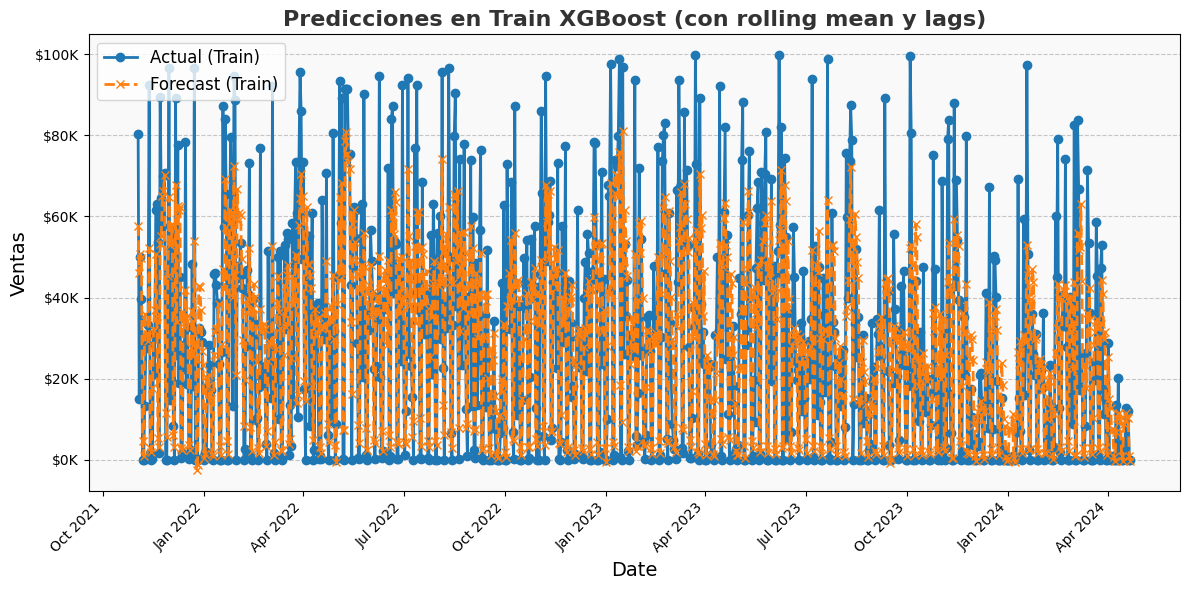

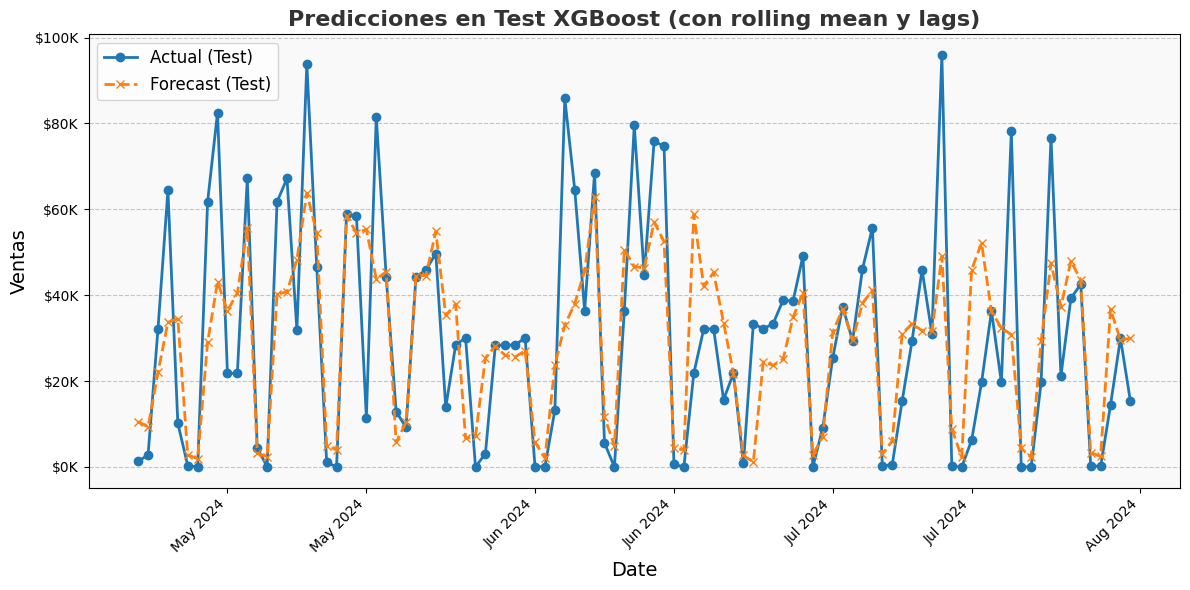

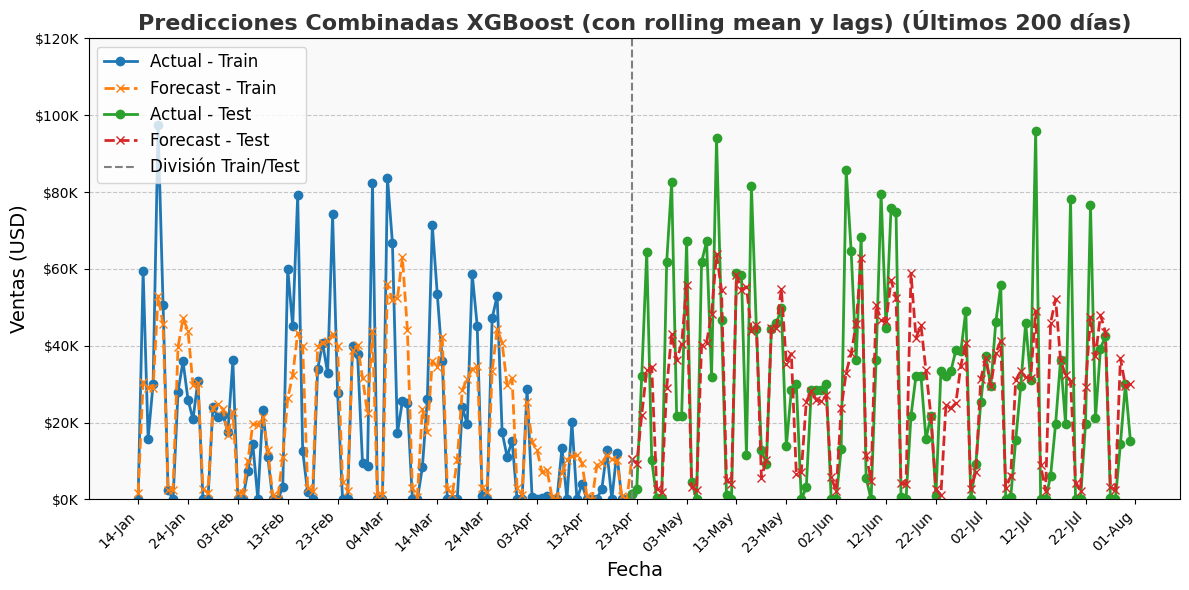

<Figure size 1000x800 with 0 Axes>

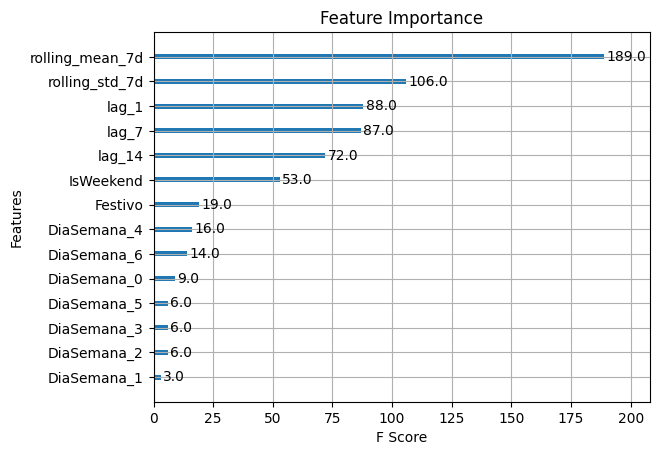

In [7]:
model.evaluate_model_predictions()
model.plot_predictions(train_title='Predicciones en Train XGBoost (con rolling mean y lags)',
    test_title='Predicciones en Test XGBoost (con rolling mean y lags)',
    divided_title='Predicciones Combinadas XGBoost (con rolling mean y lags) (Últimos 200 días)'
)
model.plot_feature_importance()

In [8]:
model_info = model.generate_model_info(version='XGBoost')

In [9]:
df_models_info = pd.DataFrame([model_info]).round(2)
df_models_info

,version,model_name,rmse_train,mae_train,r2_train,rmse_test,mae_test,r2_test
0,XGBoost,XGBRegressor,15510.8,11218.9,0.69,17866.77,12555.63,0.53


### 4. Serie Transformada

In [10]:
model_log = XGBoostTimeSeriesLog(data=data, target='Ventas_Log', test_days=test_days)
model_log.preprocess_data()
model_log.train_model()

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:06:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:06:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:06:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

Mejores hiperparámetros: {'tree_method': 'gpu_hist', 'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
RMSE en el conjunto de prueba: 1.287152142213953


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

RMSE Train: 17333.417895225117
MAE Train: 10682.380455386712
R² Train: 0.6151179541307276
RMSE Test: 19141.902190589597
MAE Test: 13257.554911772671
R² Test: 0.4617543519352876


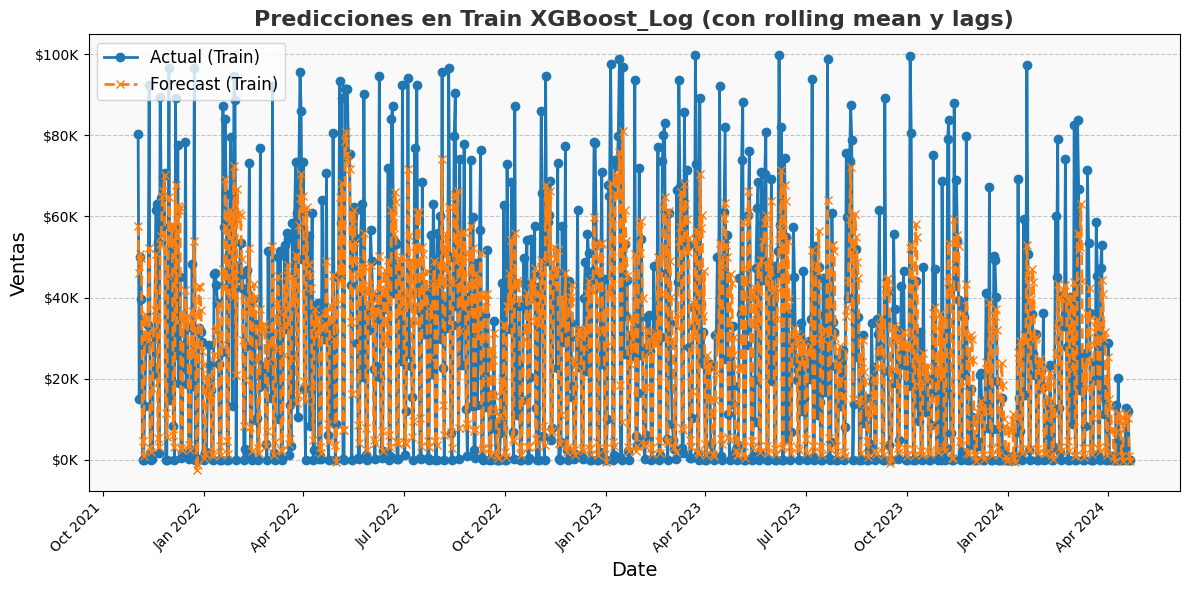

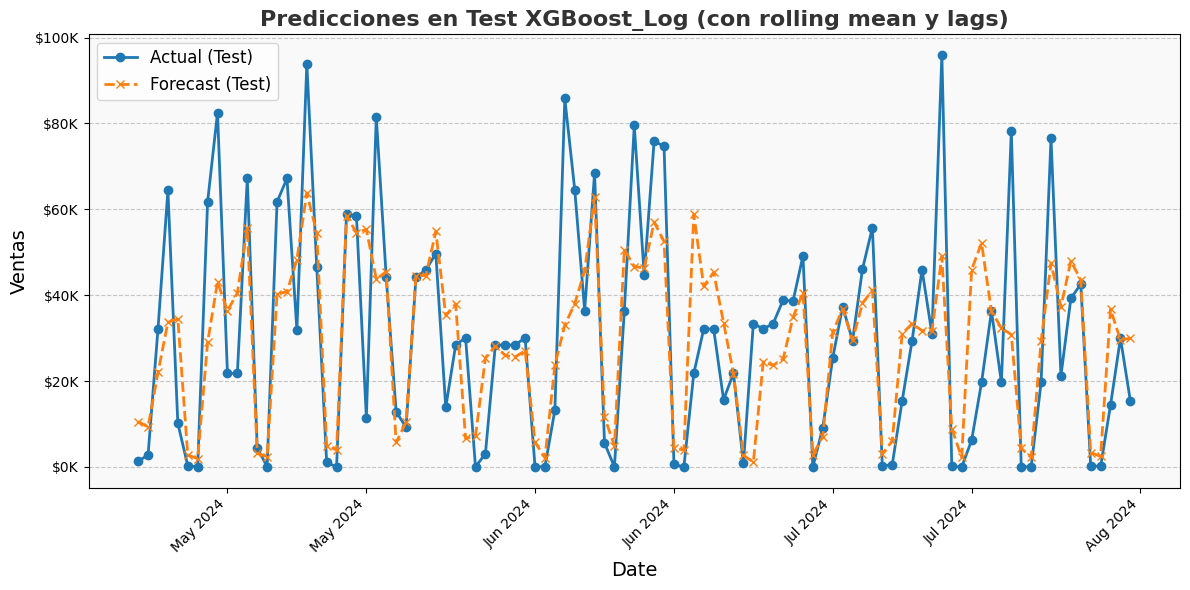

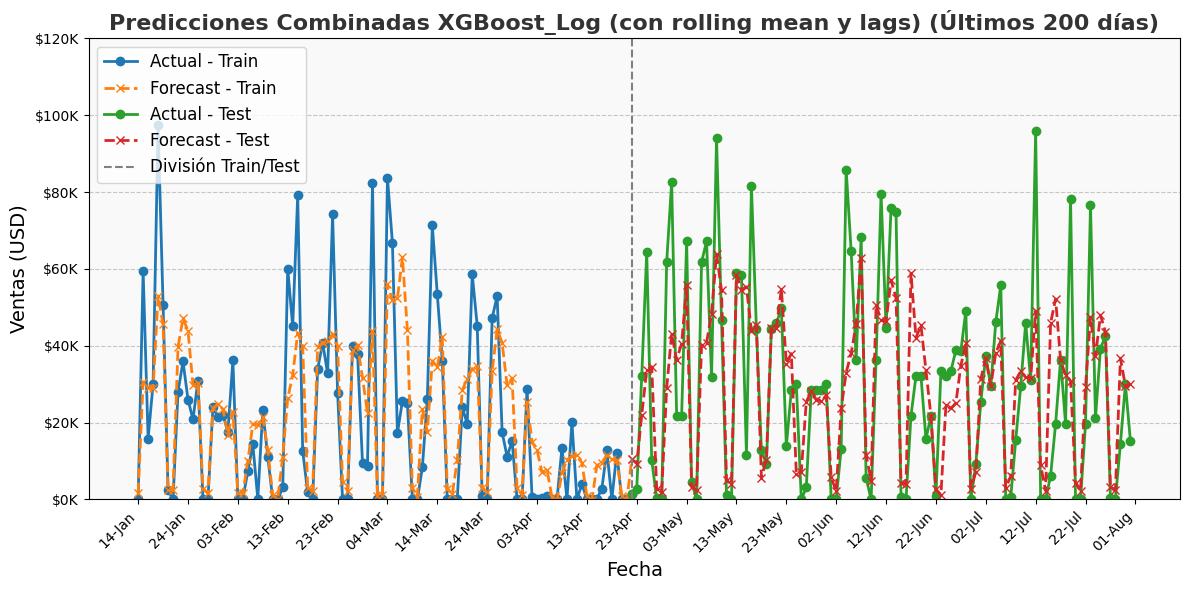

<Figure size 1000x800 with 0 Axes>

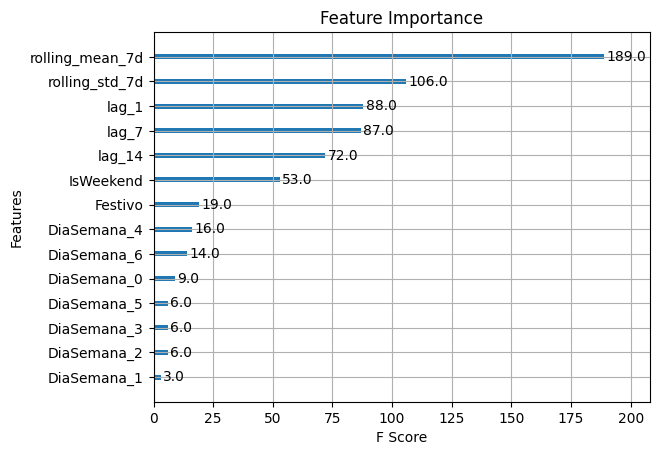

In [11]:
model_log.evaluate_model_predictions()
model.plot_predictions(train_title='Predicciones en Train XGBoost_Log (con rolling mean y lags)',
    test_title='Predicciones en Test XGBoost_Log (con rolling mean y lags)',
    divided_title='Predicciones Combinadas XGBoost_Log (con rolling mean y lags) (Últimos 200 días)'
)
model.plot_feature_importance()

In [12]:
model_info_log = model_log.generate_model_info(version='XGBoost Log')

In [13]:
df_models_info = pd.concat([df_models_info, pd.DataFrame([model_info_log])], ignore_index=True)
df_models_info

,version,model_name,rmse_train,mae_train,r2_train,rmse_test,mae_test,r2_test
0,XGBoost,XGBRegressor,15510.800000,11218.900000,0.690000,17866.770000,12555.630000,0.530000
1,XGBoost Log,XGBRegressor,17333.417895,10682.380455,0.615118,19141.902191,13257.554912,0.461754


### 5. Exportar Resultados

In [14]:
ruta = '/kaggle/working/xgboost.csv'
df_models_info.to_csv(ruta, index=False)